In [1]:
# NBA Game Data Analysis

## This notebook analyzes clean NBA game data from the 2017-18 through 2023-24 seasons to identify patterns that will inform our prediction model. The data has been filtered to include only regular season and playoff games for the 30 official NBA teams.

## Data Loading and Overview
    
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from datetime import datetime

# Set visualization styles for better-looking plots
plt.style.use('fivethirtyeight')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Find and load the most recent cleaned game data file
clean_files = glob.glob('../data/processed/nba_games_clean_*.csv')
latest_file = max(clean_files, key=os.path.getctime)
print(f"Loading clean NBA data from: {latest_file}")

# Find and load the most recent cleaned game data file
clean_files = glob.glob('../data/processed/nba_games_clean_*.csv')
if not clean_files:
    raise FileNotFoundError("No cleaned NBA game data files found. Please run the data collection script first.")
    
latest_file = max(clean_files, key=os.path.getctime)
print(f"Loading clean NBA data from: {latest_file}")

# Load the data
games_df = pd.read_csv(latest_file)

# Load the data
games_df = pd.read_csv(latest_file)

# Convert date to datetime
games_df['GAME_DATE'] = pd.to_datetime(games_df['GAME_DATE'])

# Add some useful derived columns
games_df['HOME'] = games_df['MATCHUP'].str.contains('vs').astype(int)
games_df['WIN'] = (games_df['WL'] == 'W').astype(int)

# Display basic information about the dataset
print(f"Dataset shape: {games_df.shape} (rows, columns)")
print(f"Seasons covered: {sorted(games_df['SEASON'].unique())}")
print(f"Date range: {pd.to_datetime(games_df['GAME_DATE']).min().strftime('%Y-%m-%d')} to {pd.to_datetime(games_df['GAME_DATE']).max().strftime('%Y-%m-%d')}")
print(f"Unique games: {games_df['GAME_ID'].nunique()}")
print(f"Unique teams: {games_df['TEAM_NAME'].nunique()}")

# Check basic stats and data types
print(f"Data shape: {games_df.shape}")
print(f"Date range: {games_df['GAME_DATE'].min()} to {games_df['GAME_DATE'].max()}")
print(f"Seasons included: {sorted(games_df['SEASON'].unique())}")
print(f"Number of teams: {games_df['TEAM_NAME'].nunique()}")

# Show a few rows to understand the structure
games_df.head()


Loading clean NBA data from: ../data/processed/nba_games_clean_20250318_152105.csv
Loading clean NBA data from: ../data/processed/nba_games_clean_20250318_152105.csv
Dataset shape: (17748, 33) (rows, columns)
Seasons covered: ['2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24']
Date range: 2017-10-17 to 2024-06-17
Unique games: 8874
Unique teams: 30
Data shape: (17748, 33)
Date range: 2017-10-17 00:00:00 to 2024-06-17 00:00:00
Seasons included: ['2017-18', '2018-19', '2019-20', '2020-21', '2021-22', '2022-23', '2023-24']
Number of teams: 30


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,STL,BLK,TOV,PF,PLUS_MINUS,SEASON,GAME_TYPE,SEASON_TYPE,HOME,WIN
0,22017,1610612753,ORL,Orlando Magic,21701222,2018-04-11,ORL vs. WAS,W,239,101,...,6,7,16,27,9.0,2017-18,2,Regular Season,1,1
1,22017,1610612755,PHI,Philadelphia 76ers,21701223,2018-04-11,PHI vs. MIL,W,240,130,...,15,7,12,17,35.0,2017-18,2,Regular Season,1,1
2,22017,1610612749,MIL,Milwaukee Bucks,21701223,2018-04-11,MIL @ PHI,L,240,95,...,6,5,20,17,-35.0,2017-18,2,Regular Season,0,0
3,22017,1610612751,BKN,Brooklyn Nets,21701219,2018-04-11,BKN @ BOS,L,240,97,...,10,6,15,12,-13.0,2017-18,2,Regular Season,0,0
4,22017,1610612752,NYK,New York Knicks,21701220,2018-04-11,NYK @ CLE,W,239,110,...,10,3,15,22,12.0,2017-18,2,Regular Season,0,1


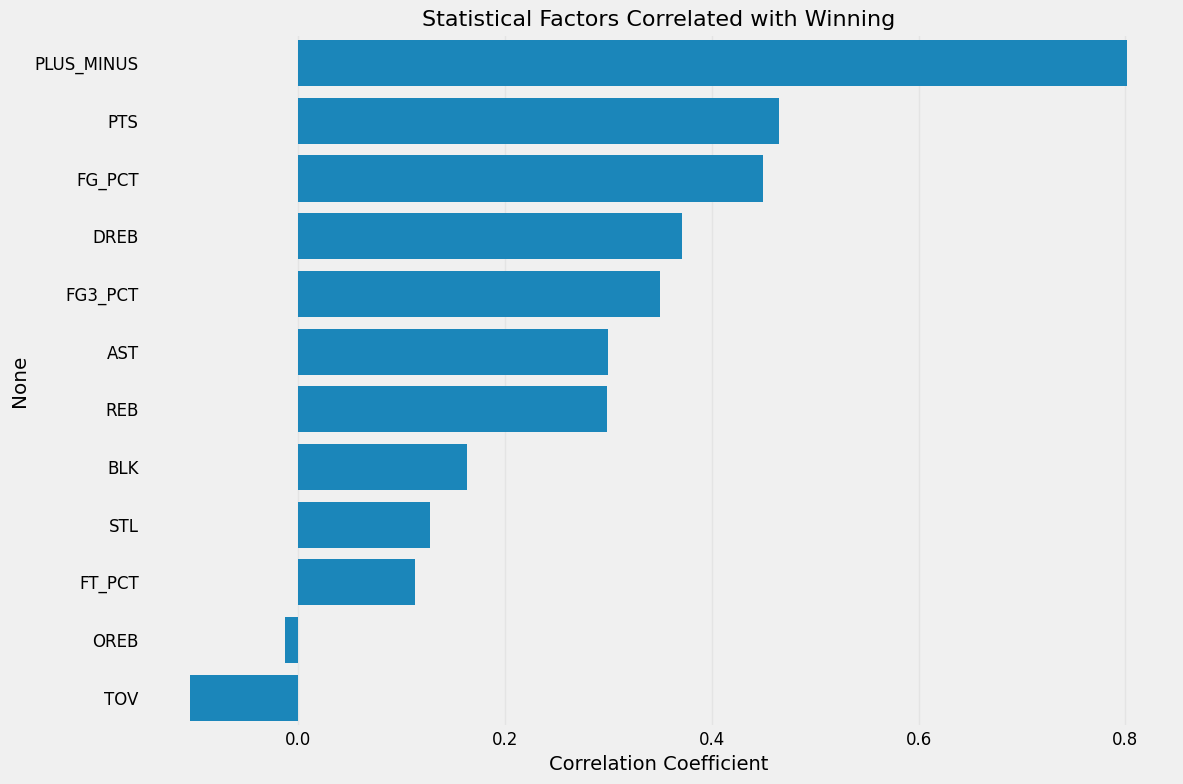

Top 5 factors most correlated with winning:
1. PLUS_MINUS: 0.8016
2. PTS: 0.4653
3. FG_PCT: 0.4493
4. DREB: 0.3716
5. FG3_PCT: 0.3502


In [2]:
# Create correlation matrix with win outcome
win_corr_columns = ['WIN', 'PTS', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'OREB', 'DREB', 
                     'REB', 'AST', 'STL', 'BLK', 'TOV', 'PLUS_MINUS']
win_corr = games_df[win_corr_columns].corr()

# Visualize correlation with winning
plt.figure(figsize=(12, 8))
win_corrs = win_corr['WIN'].sort_values(ascending=False).drop('WIN')
sns.barplot(x=win_corrs.values, y=win_corrs.index)
plt.title('Statistical Factors Correlated with Winning', fontsize=16)
plt.xlabel('Correlation Coefficient', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("Top 5 factors most correlated with winning:")
for i, (factor, corr) in enumerate(win_corrs.head(5).items()):
    print(f"{i+1}. {factor}: {corr:.4f}")

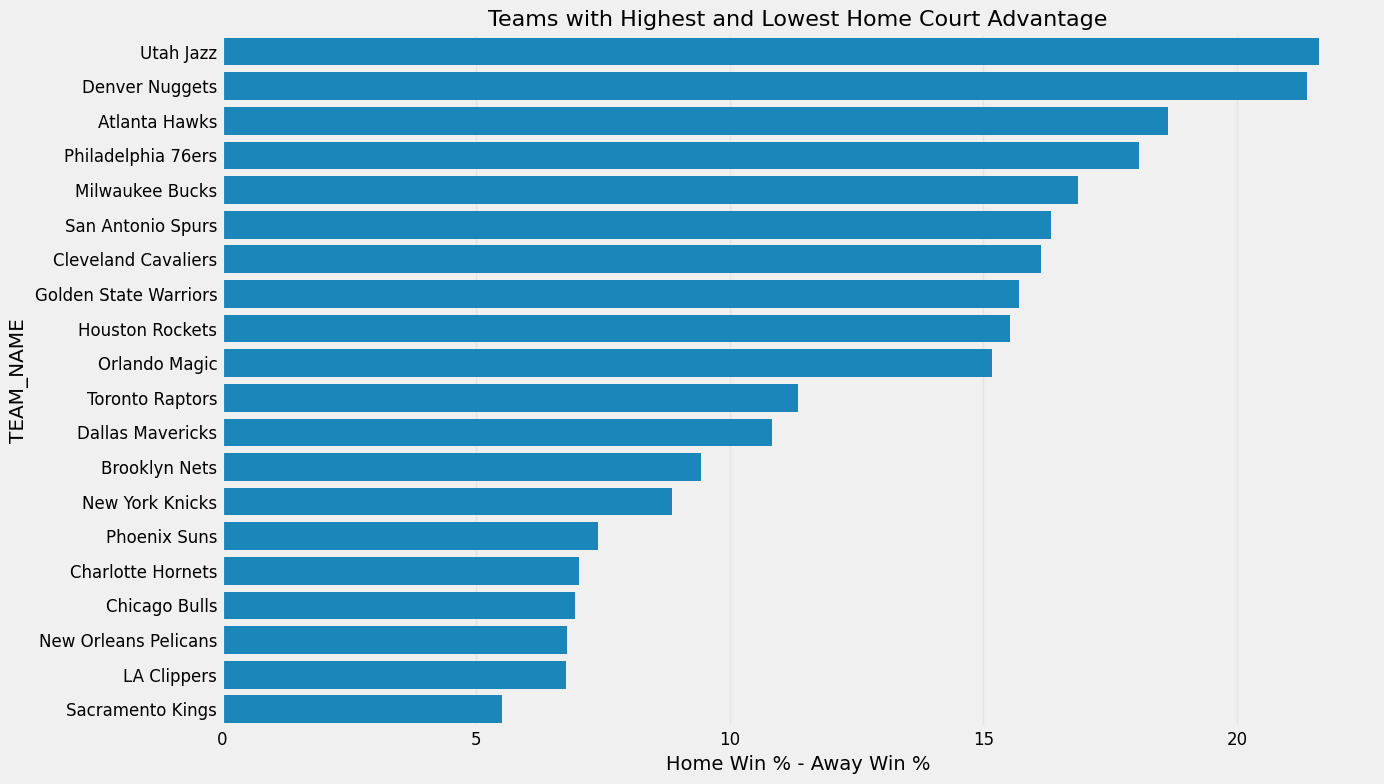

In [3]:
# Calculate team performance metrics
team_stats = games_df.groupby('TEAM_NAME').agg({
    'WIN': 'mean',
    'PTS': 'mean',
    'PLUS_MINUS': 'mean',
    'FG_PCT': 'mean',
    'FG3_PCT': 'mean',
    'REB': 'mean',
    'AST': 'mean',
    'TOV': 'mean',
    'GAME_ID': 'count'
}).rename(columns={'GAME_ID': 'GAMES_PLAYED', 'WIN': 'WIN_PCT'})

team_stats['WIN_PCT'] *= 100  # Convert to percentage

# Calculate home/away win rates by team
home_away_stats = games_df.groupby(['TEAM_NAME', 'HOME']).agg({
    'WIN': 'mean',
    'PTS': 'mean',
    'PLUS_MINUS': 'mean'
}).rename(columns={'WIN': 'WIN_PCT'})

home_away_stats['WIN_PCT'] *= 100  # Convert to percentage

# Reshape for easier comparison
home_away_pivot = home_away_stats['WIN_PCT'].unstack()
home_away_pivot.columns = ['Away Win %', 'Home Win %']
home_away_pivot['Home Court Advantage'] = home_away_pivot['Home Win %'] - home_away_pivot['Away Win %']
home_away_pivot = home_away_pivot.sort_values('Home Court Advantage', ascending=False)

# Visualize teams with highest and lowest home court advantage
plt.figure(figsize=(14, 8))
top_bottom_teams = pd.concat([home_away_pivot.head(10), home_away_pivot.tail(10)])
sns.barplot(x='Home Court Advantage', y=top_bottom_teams.index, data=top_bottom_teams.reset_index())
plt.title('Teams with Highest and Lowest Home Court Advantage', fontsize=16)
plt.xlabel('Home Win % - Away Win %', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [4]:
# Create a function to analyze matchup dynamics
def analyze_matchups(df):
    # Create a dictionary to store matchup records
    matchup_records = {}
    
    # Iterate through teams to find their performance against each opponent
    for team in df['TEAM_NAME'].unique():
        team_games = df[df['TEAM_NAME'] == team]
        
        for opponent in df['TEAM_NAME'].unique():
            if team == opponent:
                continue
                
            # Find games against this opponent
            vs_opponent = team_games[team_games['MATCHUP'].str.contains(opponent)]
            
            if len(vs_opponent) > 0:
                win_pct = vs_opponent['WIN'].mean() * 100
                avg_margin = vs_opponent['PLUS_MINUS'].mean()
                matchup_records[(team, opponent)] = {
                    'games': len(vs_opponent),
                    'win_pct': win_pct,
                    'avg_margin': avg_margin
                }
    
    # Convert to DataFrame
    matchup_df = pd.DataFrame([
        {
            'team': team,
            'opponent': opponent,
            'games': data['games'],
            'win_pct': data['win_pct'],
            'avg_margin': data['avg_margin']
        }
        for (team, opponent), data in matchup_records.items()
    ])
    
    return matchup_df

# Get matchup records
matchup_df = analyze_matchups(games_df)

# Find most and least favorable matchups
matchup_summary = matchup_df[matchup_df['games'] >= 5].sort_values('win_pct', ascending=False)

print("Most favorable matchups (min 5 games):")
print(matchup_summary.head(10)[['team', 'opponent', 'games', 'win_pct', 'avg_margin']])

print("\nLeast favorable matchups (min 5 games):")
print(matchup_summary.tail(10)[['team', 'opponent', 'games', 'win_pct', 'avg_margin']])

# Create a heatmap for a subset of teams (e.g., top 10 teams)
top_teams = team_stats.sort_values('WIN_PCT', ascending=False).head(10).index.tolist()
top_matchups = matchup_df[(matchup_df['team'].isin(top_teams)) & (matchup_df['opponent'].isin(top_teams))]

# Create a pivot table
matchup_pivot = top_matchups.pivot(index='team', columns='opponent', values='win_pct')

# Visualize the matchup matrix
plt.figure(figsize=(14, 12))
sns.heatmap(matchup_pivot, annot=True, cmap='YlGnBu', fmt='.1f', linewidths=.5)
plt.title('Win Percentage Matrix for Top 10 Teams (Row vs. Column)', fontsize=16)
plt.tight_layout()
plt.show()

KeyError: 'games'

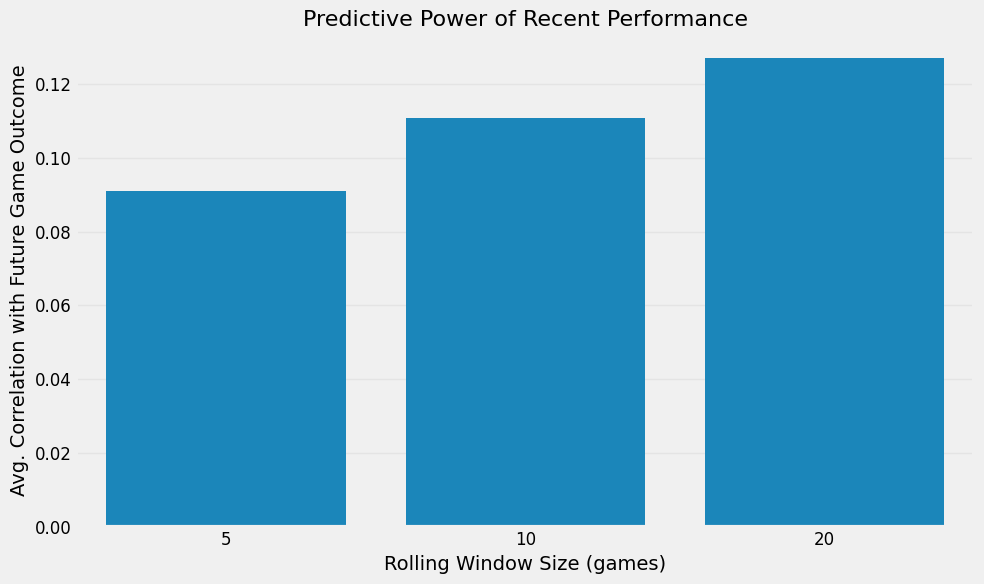

In [5]:
# Calculate rolling performance metrics
def calculate_rolling_metrics(df, window_sizes=[5, 10, 20]):
    """Calculate rolling performance metrics for all teams"""
    # Sort by team and date
    df = df.sort_values(['TEAM_NAME', 'GAME_DATE'])
    
    # Initialize dataframe for results
    rolling_metrics = pd.DataFrame()
    
    # Process each team separately
    for team in df['TEAM_NAME'].unique():
        team_df = df[df['TEAM_NAME'] == team].copy()
        
        # Calculate rolling metrics for different window sizes
        for window in window_sizes:
            team_df[f'WIN_PCT_{window}G'] = team_df['WIN'].rolling(window=window, min_periods=1).mean()
            team_df[f'PTS_LAST_{window}G'] = team_df['PTS'].rolling(window=window, min_periods=1).mean()
            team_df[f'DIFF_LAST_{window}G'] = team_df['PLUS_MINUS'].rolling(window=window, min_periods=1).mean()
        
        rolling_metrics = pd.concat([rolling_metrics, team_df])
    
    return rolling_metrics

# Calculate rolling metrics
rolling_df = calculate_rolling_metrics(games_df)

# Analyze how predictive recent performance is for future games
# Compare rolling win % with future game outcomes
future_predictive = []

for window in [5, 10, 20]:
    # Group by team
    for team in rolling_df['TEAM_NAME'].unique():
        team_games = rolling_df[rolling_df['TEAM_NAME'] == team].copy()
        
        # Skip if too few games
        if len(team_games) <= window:
            continue
            
        # Shift the rolling win % to align with future games
        team_games[f'FUTURE_WIN'] = team_games['WIN'].shift(-1)
        
        # Skip last game (no future game)
        team_games = team_games.dropna(subset=['FUTURE_WIN'])
        
        # Calculate correlation between rolling win % and future game outcome
        correlation = team_games[[f'WIN_PCT_{window}G', 'FUTURE_WIN']].corr().iloc[0, 1]
        
        future_predictive.append({
            'team': team,
            'window': window,
            'correlation': correlation
        })

# Convert to DataFrame
future_pred_df = pd.DataFrame(future_predictive)

# Group by window size
window_corr = future_pred_df.groupby('window')['correlation'].mean()

# Visualize predictive power of different window sizes
plt.figure(figsize=(10, 6))
sns.barplot(x=window_corr.index, y=window_corr.values)
plt.title('Predictive Power of Recent Performance', fontsize=16)
plt.xlabel('Rolling Window Size (games)', fontsize=14)
plt.ylabel('Avg. Correlation with Future Game Outcome', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

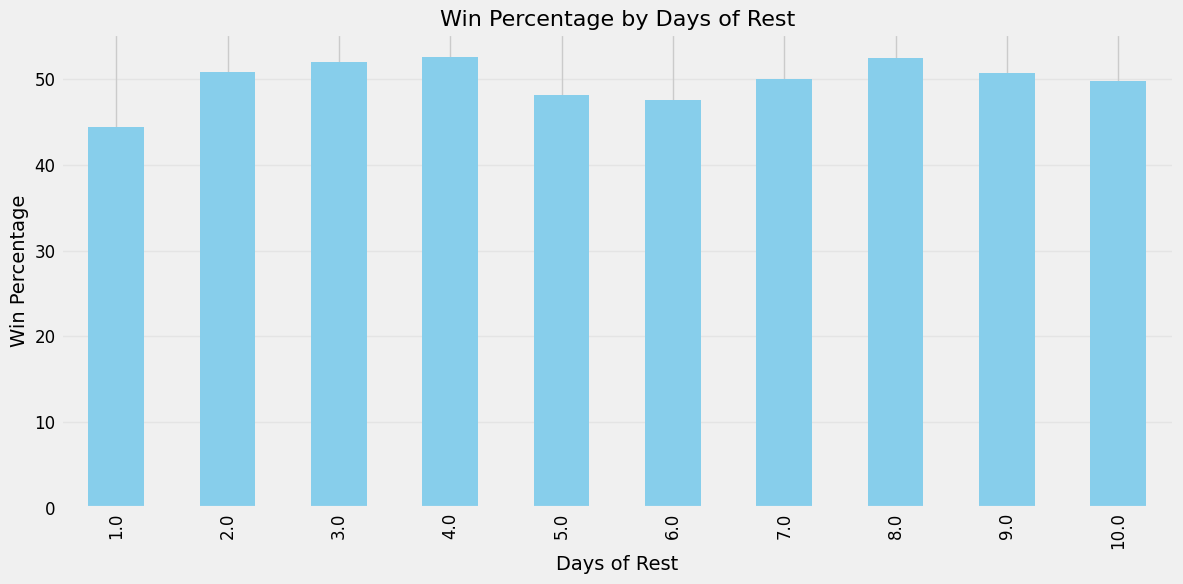

Impact of back-to-back games:
                         WIN         PTS  PLUS_MINUS  GAME_ID
HOME BACK_TO_BACK                                            
0    0             43.599279  110.207685   -2.168109     8874
1    0             56.400721  112.377507    2.171016     8874


In [6]:
# Calculate rest days between games
def calculate_rest_factors(df):
    """Calculate rest days and other schedule-related factors"""
    # Sort by team and date
    df = df.sort_values(['TEAM_NAME', 'GAME_DATE'])
    
    # Initialize dataframe for results
    context_factors = pd.DataFrame()
    
    # Process each team separately
    for team in df['TEAM_NAME'].unique():
        team_df = df[df['TEAM_NAME'] == team].copy()
        
        # Calculate days since previous game
        team_df['PREV_GAME_DATE'] = team_df['GAME_DATE'].shift(1)
        team_df['DAYS_REST'] = (team_df['GAME_DATE'] - team_df['PREV_GAME_DATE']).dt.days
        
        # Handle first game and season breaks
        team_df['DAYS_REST'] = team_df['DAYS_REST'].fillna(3)  # Assume average rest for first game
        team_df.loc[team_df['DAYS_REST'] > 10, 'DAYS_REST'] = 10  # Cap extremely large values
        
        # Create back-to-back indicator
        team_df['BACK_TO_BACK'] = (team_df['DAYS_REST'] == 0).astype(int)
        
        # Identify long road trips and home stands
        team_df['HOME_STREAK'] = team_df['HOME'].groupby((team_df['HOME'] != team_df['HOME'].shift()).cumsum()).cumcount() + 1
        
        # Mark 3rd game in 4 nights
        team_df['GAME_3_IN_4_NIGHTS'] = False
        for i in range(3, len(team_df)):
            if (team_df.iloc[i]['GAME_DATE'] - team_df.iloc[i-3]['GAME_DATE']).days <= 4:
                team_df.iloc[i, team_df.columns.get_loc('GAME_3_IN_4_NIGHTS')] = True
        
        context_factors = pd.concat([context_factors, team_df])
    
    return context_factors

# Calculate contextual factors
context_df = calculate_rest_factors(games_df)

# Analyze impact of rest days on performance
rest_impact = context_df.groupby('DAYS_REST').agg({
    'WIN': 'mean',
    'PTS': 'mean',
    'PLUS_MINUS': 'mean',
    'GAME_ID': 'count'
}).rename(columns={'GAME_ID': 'GAMES', 'WIN': 'WIN_PCT'})

rest_impact['WIN_PCT'] *= 100  # Convert to percentage

# Visualize impact of rest
plt.figure(figsize=(12, 6))
rest_impact['WIN_PCT'].plot(kind='bar', color='skyblue')
plt.title('Win Percentage by Days of Rest', fontsize=16)
plt.xlabel('Days of Rest', fontsize=14)
plt.ylabel('Win Percentage', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze back-to-back performance
b2b_impact = context_df.groupby(['HOME', 'BACK_TO_BACK']).agg({
    'WIN': 'mean',
    'PTS': 'mean', 
    'PLUS_MINUS': 'mean',
    'GAME_ID': 'count'
})

b2b_impact['WIN'] *= 100  # Convert to percentage
print("Impact of back-to-back games:")
print(b2b_impact)

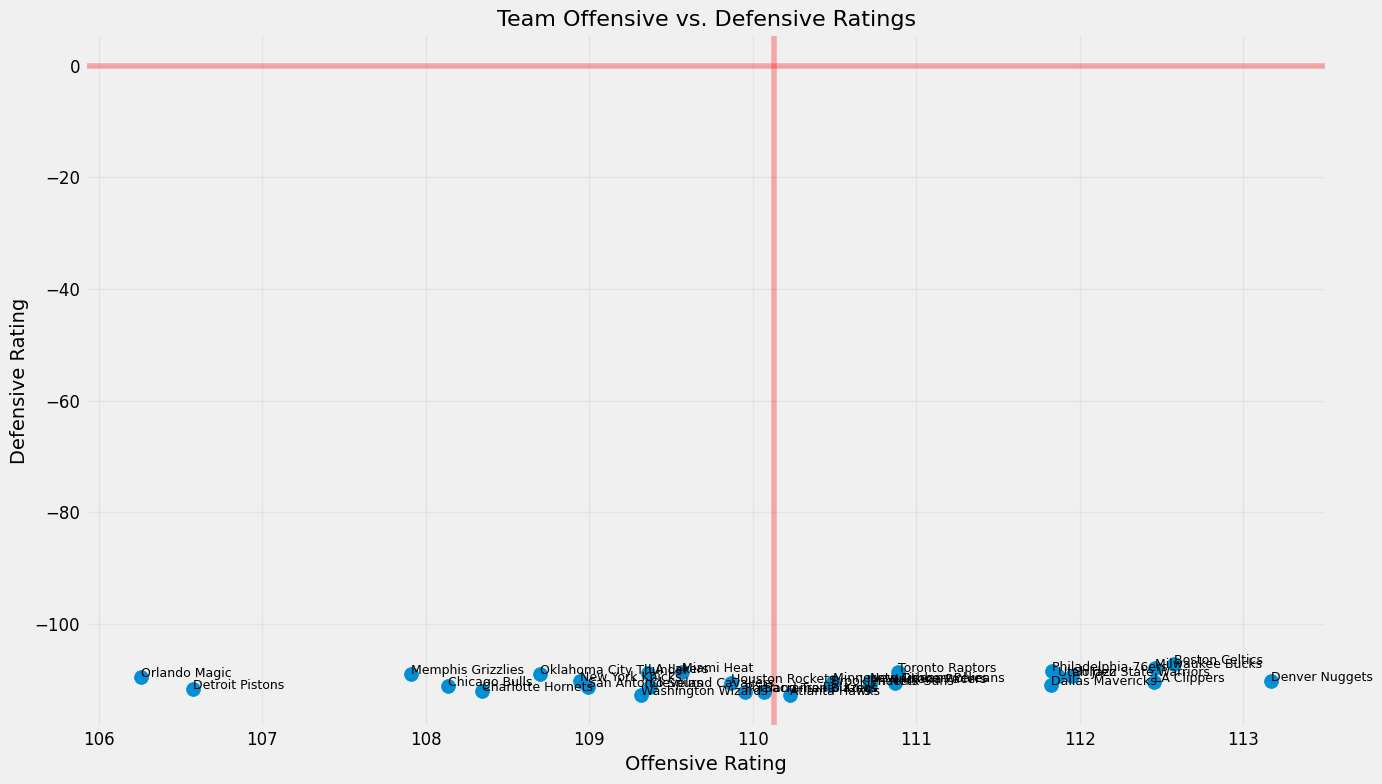

In [7]:
# Calculate per-possession metrics for teams
games_df['POSS_ESTIMATE'] = games_df['FGA'] - games_df['OREB'] + games_df['TOV'] + 0.44 * games_df['FTA']
games_df['OFF_RTG'] = games_df['PTS'] / games_df['POSS_ESTIMATE'] * 100
games_df['DEF_RTG'] = games_df['PLUS_MINUS'] - games_df['OFF_RTG']

# Calculate team ratings
team_ratings = games_df.groupby('TEAM_NAME').agg({
    'OFF_RTG': 'mean',
    'DEF_RTG': 'mean'
})

team_ratings['NET_RTG'] = team_ratings['OFF_RTG'] + team_ratings['DEF_RTG']
team_ratings = team_ratings.sort_values('NET_RTG', ascending=False)

# Visualize team ratings
plt.figure(figsize=(14, 8))
plt.scatter(team_ratings['OFF_RTG'], team_ratings['DEF_RTG'], s=100)

# Add team labels
for i, (team, row) in enumerate(team_ratings.iterrows()):
    plt.annotate(team, (row['OFF_RTG'], row['DEF_RTG']), fontsize=9)

plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.axvline(x=team_ratings['OFF_RTG'].mean(), color='r', linestyle='-', alpha=0.3)
plt.title('Team Offensive vs. Defensive Ratings', fontsize=16)
plt.xlabel('Offensive Rating', fontsize=14)
plt.ylabel('Defensive Rating', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
# Function to create features for game prediction
def create_prediction_features(df):
    """Create features for predicting game outcomes"""
    # Get rolling team metrics
    rolling_metrics = calculate_rolling_metrics(df)
    
    # Get contextual factors
    context_factors = calculate_rest_factors(rolling_metrics)
    
    # Get matchup data
    matchup_data = analyze_matchups(df)
    
    # Extract features for each game
    game_features = []
    
    # Group by game ID to pair team data
    for game_id in df['GAME_ID'].unique():
        game = context_factors[context_factors['GAME_ID'] == game_id].copy()
        
        # Skip if we don't have both teams
        if len(game) != 2:
            continue
        
        # Determine home and away teams
        home_team = game[game['HOME'] == 1]
        away_team = game[game['HOME'] == 0]
        
        # Skip if we don't have clear home/away
        if len(home_team) != 1 or len(away_team) != 1:
            continue
        
        # Get team data
        home_team = home_team.iloc[0]
        away_team = away_team.iloc[0]
        
        # Get matchup data if available
        h2h_data = matchup_data[
            (matchup_data['team'] == home_team['TEAM_NAME']) & 
            (matchup_data['opponent'] == away_team['TEAM_NAME'])
        ]
        
        h2h_win_pct = h2h_data['win_pct'].values[0] if not h2h_data.empty else 50
        
        # Create feature row
        feature_row = {
            'GAME_ID': game_id,
            'GAME_DATE': home_team['GAME_DATE'],
            'HOME_TEAM': home_team['TEAM_NAME'],
            'AWAY_TEAM': away_team['TEAM_NAME'],
            'SEASON': home_team['SEASON'],
            'SEASON_TYPE': home_team['SEASON_TYPE'],
            
            # Team performance metrics
            'HOME_WIN_PCT_10G': home_team['WIN_PCT_10G'],
            'AWAY_WIN_PCT_10G': away_team['WIN_PCT_10G'],
            'HOME_PTS_LAST_10G': home_team['PTS_LAST_10G'],
            'AWAY_PTS_LAST_10G': away_team['PTS_LAST_10G'],
            'HOME_DIFF_LAST_10G': home_team['DIFF_LAST_10G'],
            'AWAY_DIFF_LAST_10G': away_team['DIFF_LAST_10G'],
            
            # Rest factors
            'HOME_DAYS_REST': home_team['DAYS_REST'],
            'AWAY_DAYS_REST': away_team['DAYS_REST'],
            'HOME_B2B': home_team['BACK_TO_BACK'],
            'AWAY_B2B': away_team['BACK_TO_BACK'],
            
            # Matchup history
            'H2H_HOME_WIN_PCT': h2h_win_pct,
            
            # Outcome (for training)
            'HOME_TEAM_WIN': home_team['WIN'],
            'POINT_DIFF': home_team['PLUS_MINUS']
        }
        
        game_features.append(feature_row)
    
    return pd.DataFrame(game_features)

# Create prediction features
prediction_features = create_prediction_features(games_df)

# Show the first few rows of our features
print(f"Created {len(prediction_features)} prediction samples with {prediction_features.shape[1]} features")
prediction_features.head()

KeyError: 'team'

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve
from sklearn.inspection import permutation_importance

# Prepare features for modeling
def prepare_model_features(features_df):
    """Prepare features for modeling"""
    # Define features and target
    target = 'HOME_TEAM_WIN'
    
    # Numeric columns only, exclude identifiers and target
    exclude_cols = ['GAME_ID', 'GAME_DATE', 'HOME_TEAM', 'AWAY_TEAM', 
                     'SEASON', 'SEASON_TYPE', 'HOME_TEAM_WIN', 'POINT_DIFF']
    
    feature_cols = [col for col in features_df.columns 
                    if col not in exclude_cols and features_df[col].dtype in ['int64', 'float64']]
    
    X = features_df[feature_cols]
    y = features_df[target]
    
    return X, y, feature_cols

# Split data by time for evaluation
train_df = prediction_features[prediction_features['SEASON'].isin(
    ['2017-18', '2018-19', '2019-20', '2020-21', '2021-22'])]
test_df = prediction_features[prediction_features['SEASON'] == '2022-23']

X_train, y_train, feature_cols = prepare_model_features(train_df)
X_test, y_test, _ = prepare_model_features(test_df)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a model to evaluate feature importance
print("Training a logistic regression model to evaluate features...")
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Evaluate model performance
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

print(f"Test accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Test ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

# Analyze feature importance
coef = pd.Series(model.coef_[0], index=feature_cols)
importance = coef.abs().sort_values(ascending=False)

# Visualize feature importance
plt.figure(figsize=(12, 8))
importance.head(15).plot(kind='bar')
plt.title('Top 15 Most Important Features (Logistic Regression)', fontsize=16)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Coefficient Magnitude', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate permutation importance (more reliable for feature importance)
print("Calculating permutation importance (this may take a moment)...")
perm_importance = permutation_importance(model, X_test_scaled, y_test, n_repeats=10,
                                         random_state=42, n_jobs=-1)

perm_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': perm_importance.importances_mean
}).sort_values('Importance', ascending=False)

# Visualize permutation importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df.head(15))
plt.title('Top 15 Most Important Features (Permutation Importance)', fontsize=16)
plt.xlabel('Mean Decrease in Accuracy', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'prediction_features' is not defined

In [10]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, calibration_curve

# Create and train a calibrated model
base_model = LogisticRegression(random_state=42, max_iter=1000)
calibrated_model = CalibratedClassifierCV(base_model, cv=5, method='isotonic')
calibrated_model.fit(X_train_scaled, y_train)

# Generate predictions
y_prob_calibrated = calibrated_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate calibration
brier = brier_score_loss(y_test, y_prob_calibrated)
print(f"Brier score (lower is better): {brier:.4f}")

# Plot calibration curve
plt.figure(figsize=(10, 8))
prob_true, prob_pred = calibration_curve(y_test, y_prob_calibrated, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Perfect calibration line
plt.xlabel('Predicted Probability', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Calibration Curve (Reliability Diagram)', fontsize=16)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze predictions at different probability thresholds
prob_bins = pd.cut(y_prob_calibrated, bins=10)
bin_accuracy = y_test.groupby(prob_bins).mean()
bin_samples = y_test.groupby(prob_bins).count()

print("\nAccuracy by predicted probability range:")
for bin_range, acc in bin_accuracy.items():
    samples = bin_samples[bin_range]
    bin_label = f"{bin_range.left:.1f} to {bin_range.right:.1f}"
    print(f"Predicted prob {bin_label}: Actual win rate = {acc:.4f} ({samples} games)")

# Find games with significant probability mismatches between teams
test_df['PREDICTED_HOME_WIN_PROB'] = y_prob_calibrated
test_df['ACTUAL_OUTCOME'] = y_test

# Look at some high confidence predictions
high_confidence = test_df[test_df['PREDICTED_HOME_WIN_PROB'] > 0.8]
print(f"\nAnalyzing {len(high_confidence)} high confidence predictions (>80% home win):")
high_conf_accuracy = high_confidence['ACTUAL_OUTCOME'].mean()
print(f"Actual win rate for high confidence predictions: {high_conf_accuracy:.4f}")

# Look at close matchups
close_matchups = test_df[
    (test_df['PREDICTED_HOME_WIN_PROB'] > 0.45) & 
    (test_df['PREDICTED_HOME_WIN_PROB'] < 0.55)
]
print(f"\nAnalyzing {len(close_matchups)} close matchups (45-55% home win):")
close_accuracy = close_matchups['ACTUAL_OUTCOME'].mean()
print(f"Actual win rate for close matchups: {close_accuracy:.4f}")

ImportError: cannot import name 'calibration_curve' from 'sklearn.metrics' (/Users/fredwhitehouse/Documents/NBA_System/venv/lib/python3.10/site-packages/sklearn/metrics/__init__.py)